Here, we'll try to fit our very first model on TennisExplorer data

In [1]:
from tennis_new.fetch.tennis_explorer.combiner import read_joined

jd = read_joined()

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [2]:
jd.shape

(952932, 31)

#### Data Checks... 

In [3]:
# Matches are included only once?
assert jd['match_link'].value_counts().max() == 1
assert jd['match_link'].notnull().all()

In [4]:
(jd['p1_link'].isnull() | jd['p2_link'].isnull()).value_counts()

False    952872
True         60
dtype: int64

Player links are missing occasionally.  How often are they both missing?

In [5]:
(jd['p1_link'].isnull() & jd['p2_link'].isnull()).value_counts()

False    952932
dtype: int64

They are never both missing.  This is good!

In [6]:
# We should never have a score for a later set and not missing for an earlier set 
for early_set in range(1, 5):
    for later_set in range(early_set + 1, 6):
        assert ~(
            jd['p1_set%d' % early_set].isnull() &
            jd['p1_set%d' % later_set].notnull()
        ).any()
        assert ~(
            jd['p1_set%d' % early_set].isnull() &
            jd['p1_set%d' % later_set].notnull()
        ).any()

# Check that any time a score is present that it is present for both players in that set
for set_no in range(1, 6):
    print(set_no, (jd['p1_set%d' % set_no].isnull() != jd['p2_set%d' % set_no].isnull()).sum())

1 0
2 1
3 0
4 0
5 0


There is one cases where only one player is missing a score for a set...
TODO: Remove this case

Let's look at how often the winner wins 1, 2 or 3 sets...

In [7]:
jd['p1_sets_won'].value_counts()

2.0    901412
1.0     36080
3.0     15437
Name: p1_sets_won, dtype: int64

Very often, we have the winner winning only one set.  What's up with that?

In [8]:
jd[jd['p1_sets_won'] == 1]['p1_set1'].isnull().value_counts()

False    28513
True      7567
Name: p1_set1, dtype: int64

In some of these cases we have no score in the first set at all, but in the majority of these we do.  Let's look at some of the cases where the score is missing -- we will cross-reference with atptour.com

In [15]:
INVESTIGATE_COLS = [
    'match_link',
    'date',
    'tourney_name',
    'p1_sets_won',
    'p2_sets_won',
    'p1_name',
    'p2_name',
    'p1_set1',
    'p2_set1'
]


jd[jd['p1_set1'].isnull()][INVESTIGATE_COLS].head(20)

,match_link,date,tourney_name,p1_sets_won,p2_sets_won,p1_name,p2_name,p1_set1,p2_set1
4,/match-detail/?id=13797,1997-01-01,Adelaide,1.0,0.0,Tillstrom M.,Black B.,NaN,NaN
30,/match-detail/?id=13880,1997-01-06,Singapur challenger,1.0,0.0,Johnson D.,Van Lottum J.,NaN,NaN
94,/match-detail/?id=13983,1997-01-08,Sydney,1.0,0.0,Black B.,Woodbridge T.,NaN,NaN
123,/match-detail/?id=14145,1997-01-15,Australian Open,1.0,0.0,Reneberg R.,Burrieza-Lopez O.,NaN,NaN
534,/match-detail/?id=14603,1997-02-14,Dubai,1.0,0.0,Ivanisevic G.,Becker B.,NaN,NaN
604,/match-detail/?id=14796,1997-02-18,Antwerp,1.0,0.0,Norman D.,Ulihrach B.,NaN,NaN
710,/match-detail/?id=14815,1997-02-21,Antwerp,1.0,0.0,Goellner M.,Damm M.,NaN,NaN
788,/match-detail/?id=14972,1997-02-25,Salinas challenger,1.0,0.0,Hernandez A.,Rikl D.,NaN,NaN
927,/match-detail/?id=15105,1997-03-07,Rotterdam,1.0,0.0,Ivanisevic G.,Korda P.,NaN,NaN
1062,/match-detail/?id=15303,1997-03-20,Saint Petersburg,1.0,0.0,Clement A.,Rusedski G.,NaN,NaN


Above, based on looking through atptour.com manually, these are a mixture of walkovers and first-set retirements.  Unforunately, it does not look like we have a straightforward way of distinguishing between the two.  Now, let's look at the cases where p1_sets_won == 1 and p1_set1 is *not null.*

In [10]:
jd[
    (jd['p1_sets_won'] == 1) &
    (jd['p1_set1'].notnull())
][[
    'date',
    'tourney_name',
    'p1_name',
    'p2_name',
    'p1_set1',
    'p1_set2',
    'p1_set3',
    'p1_set4',
    'p1_set5',
    'p2_set1',
    'p2_set2',
    'p2_set3',
    'p2_set4',
    'p2_set5',
]].head(20)

,date,tourney_name,p1_name,p2_name,p1_set1,p1_set2,p1_set3,p1_set4,p1_set5,p2_set1,p2_set2,p2_set3,p2_set4,p2_set5
135,1997-01-15,Australian Open,Stafford G.,Burillo J.,6.0,6.0,3.0,NaN,NaN,0.0,1.0,0.0,NaN,NaN
174,1997-01-15,Australian Open,Tramacchi P.,Van Herck J.,6.0,6.0,6.0,3.0,NaN,7.0,3.0,4.0,2.0,NaN
228,1997-01-18,Australian Open,Hrbaty D.,Berasategui A.,6.0,7.0,6.0,2.0,NaN,3.0,6.0,7.0,0.0,NaN
241,1997-01-20,Australian Open,Costa A.,Ferreira W.,6.0,6.0,3.0,NaN,NaN,3.0,2.0,2.0,NaN,NaN
359,1997-01-31,Zagreb,Ivanisevic G.,Radulescu A.,6.0,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN
377,1997-02-03,Wolfsburg challenger,Grant G.,Golmard J.,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
480,1997-02-12,Marseille,Dreekmann H.,Champion T.,6.0,3.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN
554,1997-02-16,Marseille,Enqvist T.,Rios M.,6.0,1.0,NaN,NaN,NaN,4.0,0.0,NaN,NaN,NaN
555,1997-02-17,San Jose,Sampras P.,Rusedski G.,3.0,5.0,NaN,NaN,NaN,6.0,0.0,NaN,NaN,NaN
573,1997-02-17,Punta del Este challenger,Koubek S.,Goossens K.,2.0,7.0,5.0,NaN,NaN,6.0,5.0,0.0,NaN,NaN


These generally seem to be retirements, not walkovers.  Is the number of sets won ever null?

In [16]:
jd[
    (jd['p1_sets_won'].isnull() | jd['p2_sets_won'].isnull())
][INVESTIGATE_COLS].head(20)


,match_link,date,tourney_name,p1_sets_won,p2_sets_won,p1_name,p2_name,p1_set1,p2_set1
834330,/match-detail/?id=1602915,2017-08-28,Futures 2017,NaN,NaN,Pla Malfeito J.,Mas Mascolo A.,NaN,NaN
879877,/match-detail/?id=1701605,2018-07-03,Futures 2018,NaN,NaN,Willems J.,Davydenko P.,NaN,NaN
940571,/match-detail/?id=1839342,2019-09-24,Futures 2019,NaN,NaN,Pauffley N.,Zarichanskyy D.,NaN,NaN


Very rarely, only in three futures matches.  We will rule these matches out?  Yes, it looks like from cross-referencing that we don't always have the correct winner...

In [13]:
jd.groupby('p1_sets_won').apply(lambda x: x['p1_set1'].isnull().mean())

p1_sets_won
1.0    0.209867
2.0    0.000513
3.0    0.000196
dtype: float64

There is a very small percentage of matches where the scores are missing but multiple sets have been won.  Let's investigate some of these by cross-referencing with ATP.

In [17]:
jd[
    (jd['p1_sets_won'] > 1) &
    (jd['p1_set1'].isnull())
][INVESTIGATE_COLS].head()

,match_link,date,tourney_name,p1_sets_won,p2_sets_won,p1_name,p2_name,p1_set1,p2_set1
1686,/match-detail/?id=16090,1997-04-25,Prague challenger,2.0,0.0,Portas A.,Vicente F.,NaN,NaN
1956,/match-detail/?id=16566,1997-05-10,Hamburg,2.0,0.0,Medvedev A.,Kafelnikov Y.,NaN,NaN
5026,/match-detail/?id=20711,1997-09-23,Delray Beach challenger,2.0,0.0,Martin T.,Flach D.,NaN,NaN
5042,/match-detail/?id=20773,1997-09-23,Sevilla challenger,2.0,1.0,Calatrava A.,Munoz-Hernandez J.,NaN,NaN
5672,/match-detail/?id=21560,1997-10-21,Mexico City,2.0,1.0,Clavet F.,Gaudenzi A.,NaN,NaN


Based on some simple cross-referencing, it looks like these are simple cases of the scores being missing, but the set winnings being accurate.  So, we'll leave these rows in.

In [32]:
# Filters 
def missing_score_error(df):
    return (
        df['p1_sets_won'].isnull() |
        df['p2_sets_won'].isnull()
    )

def possible_walkover(df):
    return (
        (df['p1_sets_won'] == 1) &
        df['p1_set1'].isnull()
    )

def retirement(df):    
    return (
        (df['p1_sets_won'] == 1) &
        df['p1_set1'].notnull()
    )

def missing_pids(df):    
    return (
        df['p1_link'].isnull() | 
        df['p2_link'].isnull()
    )

#### Back to Fitting

In [55]:
# Fit only when we have the unique identifier for both players?
bad_filter = missing_pids(jd) | missing_score_error(jd)
rel = jd[~bad_filter]

In [56]:
from tennis_new.ml.elo import ELOModel

unfiltered_elo = ELOModel(winner_mod=True)

In [57]:
unfiltered_elo.fit_and_backfill(
    rel['p1_link'],
    rel['p2_link'],
    rel['match_link']
)

In [115]:
import pandas as pd

def get_test_set(df, test_min='2011-01-01', test_max='2015-01-01', test_surface=None, filter_walkovers=True):
    date_cond = (
        (df['date'] >= test_min) &
        (df['date'] < test_max)
    )
    if test_surface is None:
        surface_cond = True
    cond = date_cond & surface_cond
    if filter_walkovers:
        cond &= (~possible_walkover(df))
    return df[cond]


def eval_mod(mod, test_min='2011-01-01', test_max='2015-01-01', test_surface=None, filter_walkovers=False):
    # TODO: Filter out walkovers from test set
    history_df = pd.DataFrame(mod.history)
    test_set = get_test_set(
        rel,
        test_min=test_min,
        test_max=test_max,
        test_surface=test_surface,
        filter_walkovers=filter_walkovers
    )
    test_set = pd.merge(test_set, history_df, left_on='match_link', right_on='match_id')
    print(test_set.shape[0])
    
    accuracy = (test_set['elo_match_prediction'] > 0.5).mean()
    w_odds = test_set[
        test_set['p1_odds'].notnull() &
        test_set['p2_odds'].notnull() &
        (test_set['p1_odds'] != test_set['p2_odds'])
    ]
    n_w_odds = w_odds.shape[0]
    odds_accuracy = (w_odds['p1_odds'] < w_odds['p2_odds']).mean()
    mod_odds_accuracy = (w_odds['elo_match_prediction'] > 0.5).mean()
    return {
        'overall_accuracy': accuracy,
        'odds_accuracy': odds_accuracy,
        'model_odds_accuracy': mod_odds_accuracy,
        'n_w_odds': n_w_odds
    }

In [116]:
unfiltered_eval = eval_mod(unfiltered_elo)
unfiltered_eval

224662


{'overall_accuracy': 0.7275996830794705,
 'odds_accuracy': 0.7200428690759507,
 'model_odds_accuracy': 0.7074658387051017,
 'n_w_odds': 63449}

###### Now Try Not Fitting on Matches with Retirement

It seems reasonable that we may do better if we fit without training on walkovers and retirements

In [121]:
bad_filter = possible_walkover(rel) | missing_score_error(rel)
good_filter = ~bad_filter
bad_filter.sum(), good_filter.sum()

(7567, 945302)

In [118]:
# Try not fitting on filtered out matches
filtered_elo = ELOModel(winner_mod=True)
filtered_elo.fit_and_backfill(
    rel['p1_link'],
    rel['p2_link'],
    rel['match_link'],
    filter_mask=good_filter
)

In [119]:
filtered_eval = eval_mod(filtered_elo, )
filtered_eval

224662


{'overall_accuracy': 0.7271901790244901,
 'odds_accuracy': 0.7200428690759507,
 'model_odds_accuracy': 0.7080174628441741,
 'n_w_odds': 63449}

We do marginally better fitting only on the non-walkovers (on the part with odds anyway)...Let's do a hypothesis test here

In [120]:
from scipy.stats import chi2_contingency

ns1 = int(np.round(unfiltered_eval['model_odds_accuracy'] * unfiltered_eval['n_w_odds']))
nf1 = unfiltered_eval['n_w_odds'] - ns1

ns2 = int(np.round(filtered_eval['model_odds_accuracy'] * filtered_eval['n_w_odds']))
nf2 = filtered_eval['n_w_odds'] - ns2

arr = np.array([[ns1, nf1], [ns2, nf2]])
chi2, p, _, _ = chi2_contingency(arr)
p

0.8337765580346174

Overall, the difference is not significant -- we also see that the accuracy decreases overall, so maybe these filters aren't great?  Let's try to filter out all retirements now...

In [122]:
bad_filter = possible_walkover(rel) | missing_score_error(rel) | retirement(rel)
good_filter = ~bad_filter
bad_filter.sum(), good_filter.sum()

(36080, 916789)

In [123]:
# Try not fitting on filtered out matches
filtered_elo = ELOModel(winner_mod=True)
filtered_elo.fit_and_backfill(
    rel['p1_link'],
    rel['p2_link'],
    rel['match_link'],
    filter_mask=good_filter
)

In [124]:
filtered_eval = eval_mod(filtered_elo, )
filtered_eval

224662


{'overall_accuracy': 0.7252361325012686,
 'odds_accuracy': 0.7200428690759507,
 'model_odds_accuracy': 0.7068511718072783,
 'n_w_odds': 63449}

This is even worse!  For now, we won't do any filtering

#### Tune ELO Parameters

In [125]:
from tennis_new.ml.sobol import generate_sobol_seq, get_range_values

MIN_C = 100
MAX_C = 500
MIN_O = 0
MAX_O = 50
MIN_S = 0
MAX_S = 2


sobol_vals = generate_sobol_seq(3, 100, 1)
cs = get_range_values(MIN_C, MAX_C, sobol_vals[:, 0])
os = get_range_values(MIN_O, MAX_O, sobol_vals[:, 1])
ss = get_range_values(MIN_S, MAX_S, sobol_vals[:, 2])

In [ ]:
from tqdm.autonotebook import tqdm

out = []
for c, o, s in tqdm(zip(cs, os, ss)):
    cur_elo = ELOModel(c=c, o=o, s=s, winner_mod=True)
    cur_elo.fit_and_backfill(
        rel['p1_link'],
        rel['p2_link'],
        rel['match_link'],
        filter_mask=good_filter
    )
    cur_eval = eval_mod(cur_elo)
    cur_eval.update({'c': c, 'o': o, 's': s})
    out.append(cur_eval)

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


224662


In [27]:
tune_df = pd.DataFrame(out)

In [29]:
tune_df.sort_values('model_odds_accuracy', ascending=False, inplace=True)
tune_df.head()

,c,model_odds_accuracy,o,odds_accuracy,overall_accuracy,s
77,334.375,0.707639,4.296875,0.720043,0.723224,0.515625
27,212.500,0.707576,14.062500,0.720043,0.728917,0.312500
35,268.750,0.707182,7.031250,0.720043,0.722948,0.468750
25,462.500,0.707166,20.312500,0.720043,0.723469,0.562500
13,325.000,0.707025,21.875000,0.720043,0.730043,0.375000


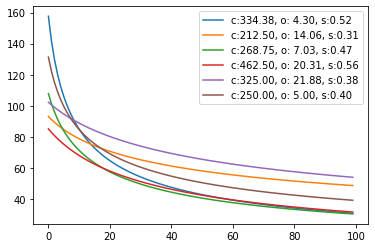

In [38]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

def _plot_params(c, o, s):
    _x = np.arange(100)
    _y = c / (_x + o) ** s
    plt.plot(_x, _y, label='c:%0.2f, o: %0.2f, s:%0.2f' % (c, o, s))
        

def _plot_row(row):
    _plot_params(row['c'], row['o'], row['s'])

for i in range(5):
    _plot_row(tune_df.iloc[i])

_default_mod = ELOModel()
_plot_params(_default_mod.c, _default_mod.o, _default_mod.s)

plt.legend()

Above, it looks like the default parameters (those suggested by ESPN) are better than what we've found through tuning.

#### Set Weighting